# Reproducing the cross resonance calculation in 1804.04073

We will try to reproduce Figure 1-4 of arXiv:1804.04073 (Magesan and Gambetta, "Effective Hamiltonian models of the cross-resonance gate", [PRA 101, 052308](https://doi.org/10.1103/PhysRevA.101.052308)).

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.30'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import logging
import numpy as np
import h5py
import matplotlib.pyplot as plt
import qudit_sim

qudit_sim.config.num_cpus = 12
qudit_sim.config.pulse_sim_solver = 'jax'

In [2]:
twopi = np.pi * 2.

hgen = qudit_sim.HamiltonianBuilder(4)
hgen.add_qudit(qubit_frequency=5.114e+9 * twopi, anharmonicity=-0.330e+9 * twopi, drive_amplitude=140.e+6 * twopi, qudit_id='q0')
hgen.add_qudit(qubit_frequency=4.914e+9 * twopi, anharmonicity=-0.330e+9 * twopi, drive_amplitude=140.e+6 * twopi, qudit_id='q1')
hgen.add_coupling('q0', 'q1', 3.8e+6 * twopi)

# Frame where the IZ component is zero in the qubit space when there is no drive
frame = qudit_sim.SystemFrame('noiz2', hgen)

In [3]:
eigenvalues = hgen.eigenvalues()
cr_drive_frequency = np.mean(eigenvalues[:2, 1] - eigenvalues[:2, 0])
cr_drive_frequency

30875986652.687454

In [4]:
amplitudes = np.linspace(0., 0.5, 10)
cycles = list(range(400, 200, -20))

In [5]:
components_list = qudit_sim.apps.find_heff(hgen,
                                           qudit='q0',
                                           frequency=cr_drive_frequency,
                                           amplitude=amplitudes,
                                           frame=frame,
                                           comp_dim=2,
                                           min_fidelity=0.3,
                                           save_result_to='cross_resonance')

In [6]:
physical_amplitudes = amplitudes * hgen.qudit_params('q0').drive_amplitude

## Figure 1

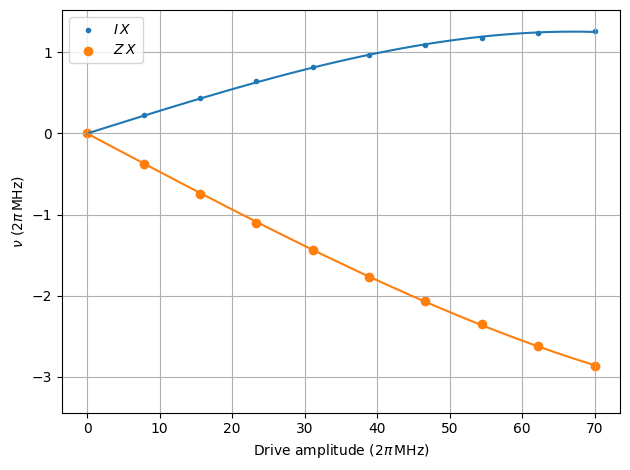

In [7]:
selection = [(0, 1), (3, 1)]
qudit_sim.visualization.plot_amplitude_scan(physical_amplitudes, components_list, select_components=selection,
                                            amp_scale=qudit_sim.FrequencyScale.MHz, compo_scale=qudit_sim.FrequencyScale.MHz);

## Figure 2

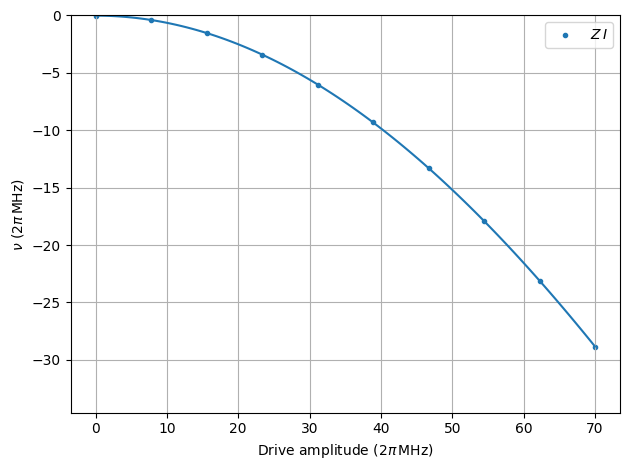

In [8]:
selection = [(3, 0)]
qudit_sim.visualization.plot_amplitude_scan(physical_amplitudes, components_list, select_components=selection,
                                            amp_scale=qudit_sim.FrequencyScale.MHz, compo_scale=qudit_sim.FrequencyScale.MHz);

## Figure 3

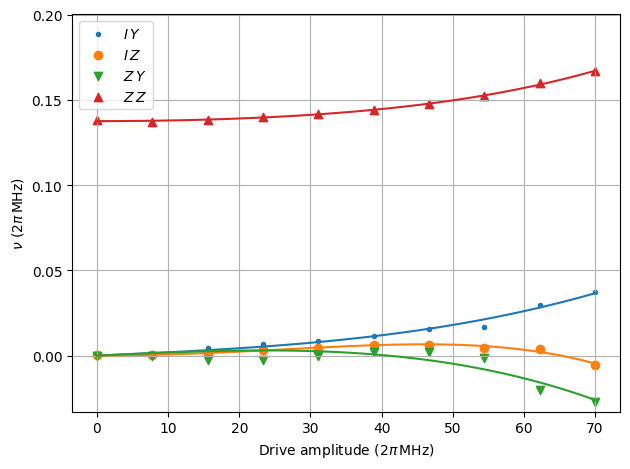

In [9]:
selection = [(0, 2), (0, 3), (3, 2), (3, 3)]
qudit_sim.visualization.plot_amplitude_scan(physical_amplitudes, components_list, select_components=selection,
                                            amp_scale=qudit_sim.FrequencyScale.MHz, compo_scale=qudit_sim.FrequencyScale.MHz);

There is some numerical precision issue in sesolve which generates spurious diagonal terms in the Hamiltonian in the presence of a pulse, regardless of the amplitude. Small-amplitude components seem to suffer from numerical instabilities in general..

## Figure 6

In [10]:
hgen_ct = hgen.copy()
hgen_ct.add_crosstalk('q0', 'q0', -1.)
hgen_ct.add_crosstalk('q0', 'q1', 0.071 * np.exp(0.62j))

components_list_ct = qudit_sim.apps.find_heff(hgen_ct,
                                              qudit='q0',
                                              frequency=cr_drive_frequency,
                                              amplitude=amplitudes,
                                              comp_dim=2,
                                              min_fidelity=0.3)

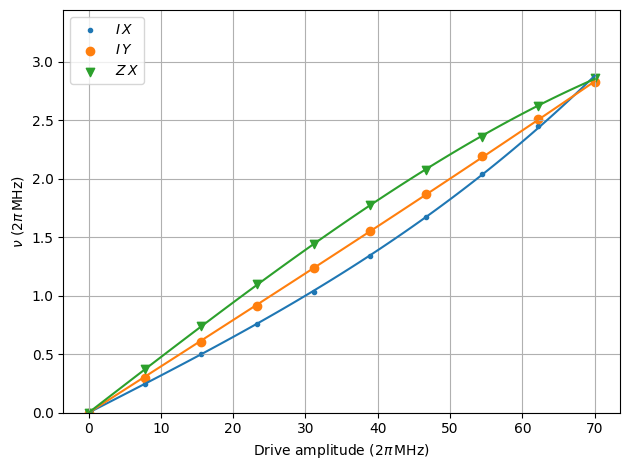

In [11]:
selection = [(0, 1), (0, 2), (3, 1)]
qudit_sim.visualization.plot_amplitude_scan(physical_amplitudes, components_list_ct, select_components=selection,
                                            amp_scale=qudit_sim.FrequencyScale.MHz, compo_scale=qudit_sim.FrequencyScale.MHz);

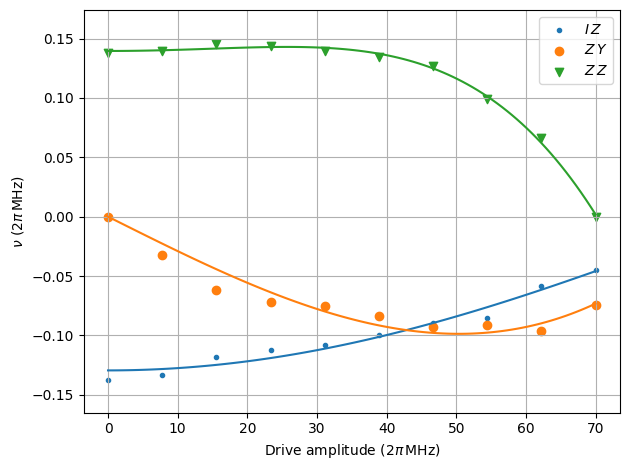

In [12]:
selection = [(0, 3), (3, 2), (3, 3)]
qudit_sim.visualization.plot_amplitude_scan(physical_amplitudes, components_list_ct, select_components=selection,
                                            amp_scale=qudit_sim.FrequencyScale.MHz, compo_scale=qudit_sim.FrequencyScale.MHz);